In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from scipy.stats import zscore

In [4]:
df=pd.read_csv('Wholesale customers data.csv')

In [5]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [9]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [11]:
X = df.drop(['Channel','Region'],axis=1)

In [13]:
scalar=StandardScaler()
X_scaled = scalar.fit_transform(X)

### K-Means

C:\Users\rishi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\rishi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\rishi\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rishi\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\rishi\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

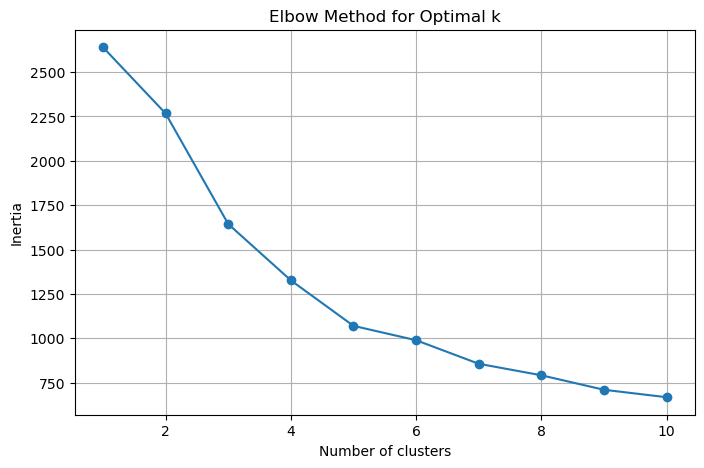

In [16]:
#Elbow Method
inertia = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [28]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

C:\Users\rishi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [32]:
df["Cluster"] = kmeans_labels
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Customer_Group,Cluster
0,2,3,12669,9656,7561,214,2674,1338,2,0
1,2,3,7057,9810,9568,1762,3293,1776,2,0
2,2,3,6353,8808,7684,2405,3516,7844,2,0
3,1,3,13265,1196,4221,6404,507,1788,1,0
4,2,3,22615,5410,7198,3915,1777,5185,1,1


In [37]:
df["Cluster"].value_counts()

Cluster
0    350
1     53
2     37
Name: count, dtype: int64

### Hierarchial Clustering

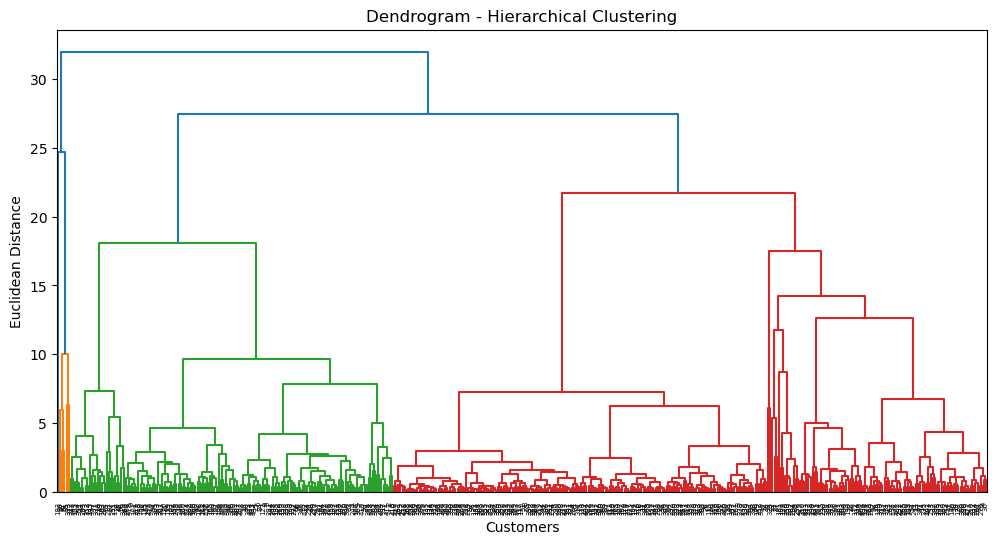

In [20]:
plt.figure(figsize=(12, 6))
dendrogram(linkage(X_scaled, method='ward'))
plt.title("Dendrogram - Hierarchical Clustering")
plt.xlabel("Customers")
plt.ylabel("Euclidean Distance")
plt.show()

In [22]:
hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clusters = hc.fit_predict(X_scaled)

In [24]:
df["Customer_Group"] = clusters

In [26]:
print(df["Customer_Group"].value_counts())

Customer_Group
1    281
2    153
0      6
Name: count, dtype: int64


### PCA

In [40]:
pca_full = PCA()
pca_full.fit(X_scaled)

PCA()

In [42]:
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

In [44]:
print("\nExplained Variance by PCA Components:")
for i, var in enumerate(explained_variance_ratio, 1):
    print(f"PC{i}: {var:.4f} (Cumulative: {cumulative_variance[i-1]:.4f})")


Explained Variance by PCA Components:
PC1: 0.4408 (Cumulative: 0.4408)
PC2: 0.2838 (Cumulative: 0.7246)
PC3: 0.1233 (Cumulative: 0.8479)
PC4: 0.0940 (Cumulative: 0.9419)
PC5: 0.0476 (Cumulative: 0.9895)
PC6: 0.0105 (Cumulative: 1.0000)


In [48]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

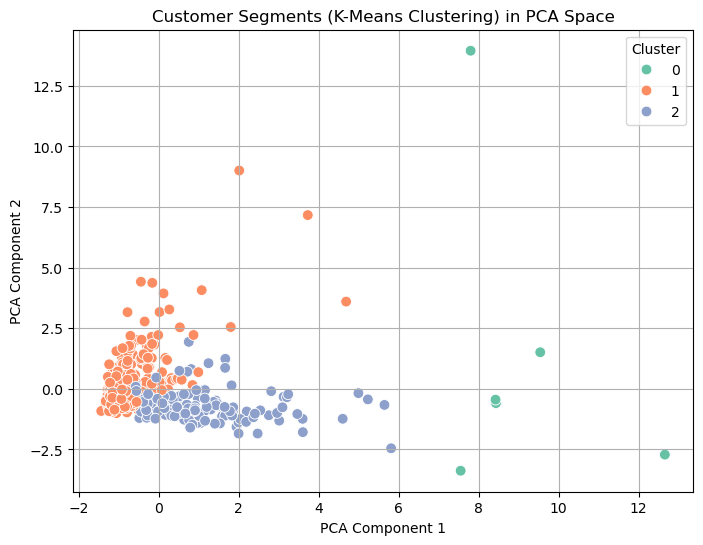

In [50]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=clusters, palette='Set2', s=60)
plt.title("Customer Segments (K-Means Clustering) in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

### Anomaly Detection

In [57]:
z_scores = np.abs(zscore(X_pca_2d))
anomalies = (z_scores > 3).any(axis=1)
df["Anomaly"] = anomalies


In [59]:
anomalous_customers = df[df["Anomaly"] == True]
print("Anomalous Customers:")
print(anomalous_customers)

Anomalous Customers:
     Channel  Region   Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
47         2       3   44466  54259    55571    7782             24171   
61         2       3   35942  38369    59598    3254             26701   
65         2       3      85  20959    45828      36             24231   
85         2       3   16117  46197    92780    1026             40827   
86         2       3   22925  73498    32114     987             20070   
87         1       3   43265   5025     8117    6312              1579   
92         2       3    9198  27472    32034    3232             18906   
93         1       3   11314   3090     2062   35009                71   
103        1       3   56082   3504     8906   18028              1480   
125        1       3   76237   3473     7102   16538               778   
181        1       3  112151  29627    18148   16745              4948   
183        1       3   36847  43950    20170   36534               239   
211        2     

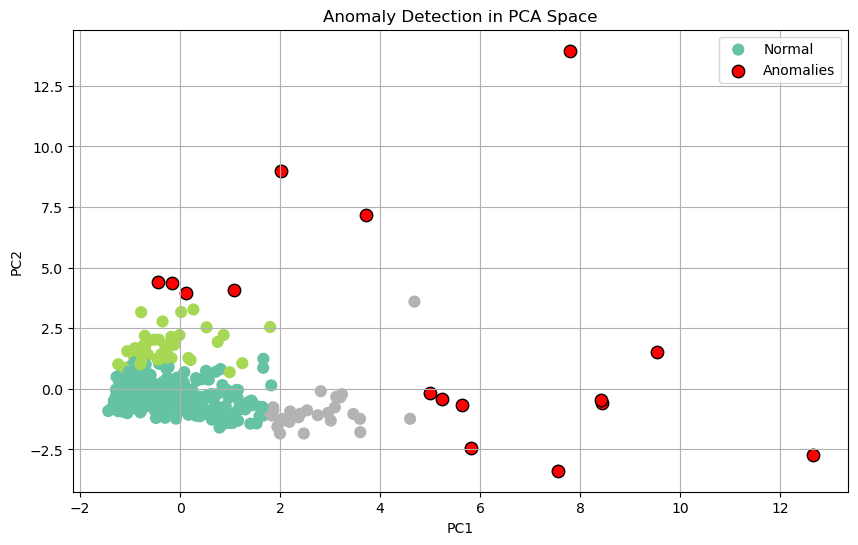

In [63]:
X_pca_2d = PCA(n_components=2).fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=df["Cluster"], cmap="Set2", s=60, label="Normal")
plt.scatter(
    X_pca_2d[anomalies, 0],
    X_pca_2d[anomalies, 1],
    c='red',
    s=80,
    edgecolors='k',
    label='Anomalies'
)
plt.title("Anomaly Detection in PCA Space")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()